# The Political Significance of Spotify - Anonymized data and source code

## Introduction

This notebook contains the necessary code for reproducing most figures in Fleischer & Kullenberg (2018) "The Political Significance of Spotify in Sweden - Analysing the #backaspotify Campaign using Twitter Data", *Culture Unbound*, Vol, No.

Even though the Twitter data was retrieved from the public-facing Twitter API, it has been anonymized cryptographically (see Appendix). The usernames and user IDs have been replaced with hashsums and the content data (Twitter messages) have been disconnected into a separate file where it has been re-ordered to prevent the content data to be connected with the meta-data. 

The network visualization from the original article has been left out of this notebook since it requires content data and meta data to be connected. 

This notebook was written by Christopher Kullenberg (christopher.kullenberg@gu.se) and is published using the MIT license (https://opensource.org/licenses/MIT). Feel free to reuse the code, but if you use it for academic publications, please cite the original article and/or this notebook.

## Contents
0. Software libraries and versions
0. Read data
0. Timeline figure of the campaign
0. Frequent users
0. Word frequencies
0. Appendix: Encryption method of original data

## 1. Software libraries and versions

In [2]:
import sys
import platform
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from collections import Counter
%matplotlib inline

In [3]:
print("SOFTWARE VERSIONS:")
print("System: " + sys.platform + ", " + os.name)
print("Platform: " + platform.platform())
print("Python: " + sys.version)
print("Pandas: " + pd.__version__)
print("Matplotlib: " + matplotlib.__version__)
print("Seaborn: " + sns.__version__)
print("NLTK: " + nltk.__version__)


SOFTWARE VERSIONS:
System: linux, posix
Platform: Linux-4.15.0-33-generic-x86_64-with-debian-buster-sid
Python: 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
Pandas: 0.22.0
Matplotlib: 2.1.2
Seaborn: 0.8.1
NLTK: 3.2.5


## 2. Read data

The anonymized data is read from two different files, that have been disconnected from each other to prevent content data to be connected to meta data:

* backaspotifyAnalysisAnonymized.csv - meta data (timestamps, hashed usernames).
* backaspotifyContentAnonymized.csv - content data of tweets, scrambled order.

The files are read into two Pandas dataframes for convenient access.

In [4]:
# Anonymized (hashed) meta-data
df = pd.read_csv("anonymized_data/backaspotifyAnalysisAnonymized.csv")

# Disordered plaintext content data
dfcontent = pd.read_csv("anonymized_data/backaspotifyContentAnonymized.csv") 

In [5]:
# Make index from timestamp with proper formatting
pd.created_at = pd.to_datetime(df.created_at, 
                               format='%Y-%m-%d %H:%M:%S')
df.index = pd.created_at
df.head()

,id,created_at,author,location,retweet_count
created_at,,,,,
2016-04-19 15:38:28,9a59905254ea6d4e37b597872c7ff8ffd34eedbb11edbb...,2016-04-19 15:38:28,bfc8763248fb4db3714b1b025db5207365a600d8c79384...,Stockholm,5
2016-04-19 15:25:31,d779f0e83afdd2f0a4cc715a66b325aa0bae4ba4fe9d07...,2016-04-19 15:25:31,b083ac71fd17558891a83b5222e991e11a795a28acf4d5...,Stockholm,0
2016-04-19 15:18:46,8ad784e1857c0e55dc34a51f99c4e88432ee09bd24d338...,2016-04-19 15:18:46,7b53accdd5c748c026036c7607784b2cf573aeb853687b...,Sweden,5
2016-04-19 15:17:37,4f1e70ec7272fd89955ef6f1946bf69f5b29dbd3b5cd05...,2016-04-19 15:17:37,faf85b4a7be25b0fa15684d7cd359b5415fd598aff0ae4...,NaN,5
2016-04-19 14:31:24,3a50141e5eb133b407a0b9a1df914dc452065d63160e5e...,2016-04-19 14:31:24,12bcc8051b172f875977e6ce834d5e89f0f10de8be445e...,Stockholm,5


In [6]:
df.index

DatetimeIndex(['2016-04-19 15:38:28', '2016-04-19 15:25:31',
               '2016-04-19 15:18:46', '2016-04-19 15:17:37',
               '2016-04-19 14:31:24', '2016-04-19 14:31:05',
               '2016-04-19 14:30:14', '2016-04-19 10:45:35',
               '2016-04-19 10:34:42', '2016-04-19 10:33:32',
               ...
               '2016-04-22 08:44:43', '2016-04-22 08:44:26',
               '2016-04-22 08:29:45', '2016-04-22 08:28:44',
               '2016-04-22 08:28:27', '2016-04-22 08:11:40',
               '2016-04-22 07:06:37', '2016-04-22 06:29:17',
               '2016-04-22 06:28:57', '2016-04-21 19:11:10'],
              dtype='datetime64[ns]', name='created_at', length=1791, freq=None)

In [7]:
""" 
Note, the order of this data has been 
intentionally disordered for the purpose of 
anonymization. There is no time-structure to it
"""
dfcontent.head()          

,tweet
0,RT @annieloof: Idag lämnar Centerpartiet in en...
1,RT @Centerpartiet: Läs @annieloof &amp; @emilk...
2,"@andquist Ja, backaspotify blev lite fjantigt,..."
3,RT @didigital_se: Missade ni veckans Digitalpo...
4,@jenskoenberg GPs ledarsida kan du sätta på re...


## 3. Timeline figure of the campaign

To detect external events qualitatively in a stream of Twitter messages, it is sometimes possible to use a timeline to reconstruct the chain of events. When spikes are found in the data, such events can be used as point of entry to see what triggered the activity. 

This figure resamples the timestamps into day-for-day chunks to make it possible to plot 
the number of Twitter messages on a readable timeline.

This is **Figure 5** in the original article.

Text(0,0.5,'Tweets')

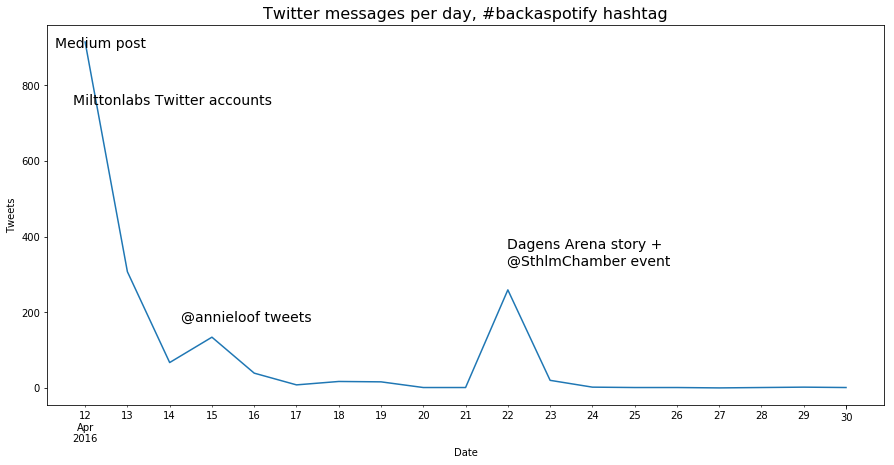

In [8]:
tweetsperday = df.resample('D').count()

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

plt.title('Twitter messages per day, \
#backaspotify hashtag', size=16)

plt.text(0.01, 0.95,'Medium post',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes, size=14)

plt.text(0.15, 0.8,'Milttonlabs Twitter accounts',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, size=14)

plt.text(0.16, 0.23,'@annieloof tweets',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes, size=14)

plt.text(0.55, 0.4,
    'Dagens Arena story +\n@SthlmChamber event',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes, size=14)

tweetsperday['id'].plot() #Plot each individual tweet per day

plt.xlabel('Date')
plt.ylabel('Tweets')

#plt.savefig('figures/figure5.eps', format='eps', dpi=600)
#plt.savefig('figures/figure5.png', format='png', dpi=600)
#plt.savefig('figures/figure5.svg', format='svg', dpi=600)

## 4. Frequent users
This function counts how many tweets each user in the dataset has produced and draws a bar plot. In this notebook the usernames are replaced with hashsums.

This is the anonymised version of **Figure 2** in the original article.

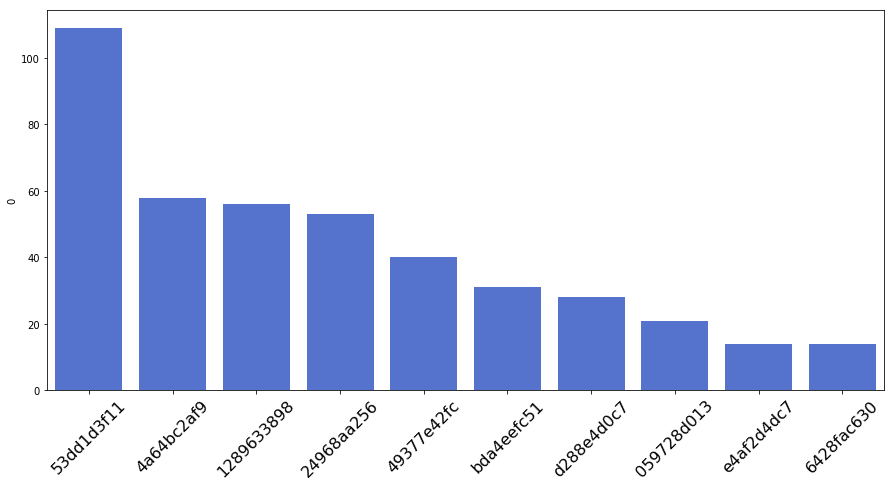

In [11]:
counter = 0
users = []
for d in df.author.iteritems():
    # the len of d is 7
    #print(d[2])
    counter += 1
    users.append(d[1][0:10]) # Ten first chars for readability, remove for print

userfreq = {}
for user in Counter(users).most_common(10):
    #print(user[0] + "\t" + str(user[1]))
    userfreq[user[0]] = user[1]

dfusers = pd.DataFrame.from_dict(userfreq, orient="index")
dfusers = dfusers.sort_values(by=0, ascending=False)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

userplot = sns.barplot(x=dfusers.index, 
                       y=dfusers[0], data=dfusers, 
                       color="royalblue")
for item in userplot.get_xticklabels():
    item.set_rotation(45)
    item.set_fontsize(16)
    

#ax.set(xlabel='Users', ylabel='Tweets')
#plt.savefig('figures/figure2.eps', format='eps', dpi=600)
#plt.savefig('figures/figure2.png', format='png', dpi=600)
#plt.savefig('figures/figure2.svg', format='svg', dpi=600)

## 4. Word frequencies
Creates a word frequency chart by counting the most frequent words. This is a very simple method for detecting the main content of discussion. There is some filtering going for the purpose of selecting only relevant words:

* URLs, @-tweets and the searched hashtag #backaspotify are removed
* The NLTK Swedish Stopwords list is used to remove words without significant meaning, such as "och", "eller", "i".

This is **Figure 1** in the original article. 

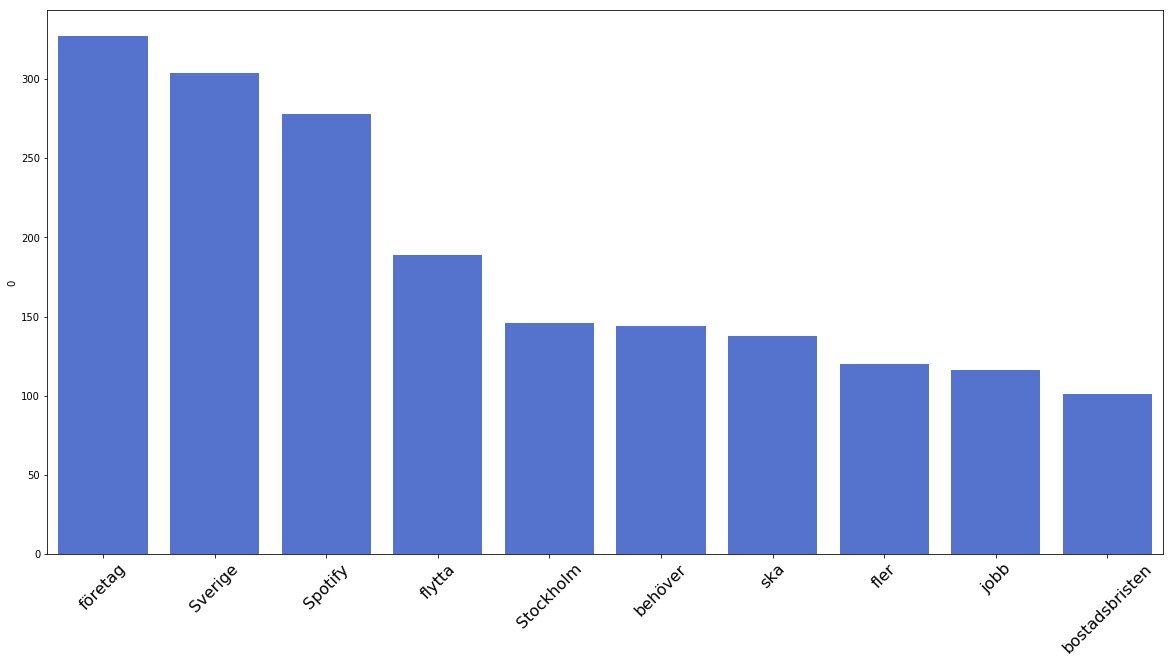

In [25]:
wordlist = []

# Extracts tokens minus Swedish stopwords
tokenlist = []
for d in dfcontent.tweet.iteritems():
    #print(stopwords.words('swedish'))
    tknzr = TweetTokenizer()
    dtokenized = tknzr.tokenize(d[1])
    #print(dtokenized)
    for token in dtokenized:
        tokenlist.append(token)
             
for t in tokenlist:
    if t not in stopwords.words('swedish'):
        if len(t) > 2: #remove short special chars like :, ;, #
            if t.startswith('http'): #remove links
                continue
            if t.startswith('@'): #remove users
                continue
            if t.startswith('#backaspotify') or t.startswith('#BackaSpotify'): #remove the core hashtags
                continue
            #print(t[0] + "\t" + str(t[1]))
            wordlist.append(t)

word_freq = Counter(wordlist).most_common(10)

wordfreqdict = {}

for w in word_freq:
    wordfreqdict[w[0]] = w[1]

dfwords = pd.DataFrame.from_dict(wordfreqdict, orient="index")
dfwords = dfwords.sort_values(by=0, ascending=False)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)


plot = sns.barplot(x=dfwords.index, y=dfwords[0], data=dfwords, color="royalblue")
for item in plot.get_xticklabels():
    item.set_rotation(45)
    item.set_fontsize(16)
    
#ax.set(xlabel='Words', ylabel='Frequency')
plt.savefig('figures/figure1_10.eps', format='eps', dpi=600)
plt.savefig('figures/figure1_10.png', format='png', dpi=600)
plt.savefig('figures/figure1_10.svg', format='svg', dpi=600)

## 5. Appendix: Encryption method of original data

To make the data very difficult to re-construct, the user names and user ids were hashed cryptographically. This way, they could be prevented from naming a specific user in the dataset, while still preserving data integrity. Moreover, the data was split up between the content of the tweets (which is searchable) and the meta-data. The two files were disorganized to make it impossible to compare them row-for-row. 

The following code was used to hash the user names and ids:

```python
import hmac
import hashlib

def encrypt(username):
    '''Takes a string as input and returns it encrypted.'''
    digest = hmac.new(b'aSecretKeyword', username.encode(), hashlib.sha256)
    encrypteusername = digest.hexdigest()
    return encrypteusername

dfanon = df
dfanon['author'] = df['author'].apply(encrypt)
dfanon['id'] = df['id'].apply(encrypt)

#dfanon.to_csv("backaspotifyAnalysisAnonymized.csv")
```